In [1]:
# pytorch loaddata from ./cow_data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tqdm import tqdm

In [2]:
# read annotation file pkl
import pickle
import pandas as pd
dataframe = pd.read_pickle('./annotations.pkl')


In [3]:
# sort index
estus = dataframe[dataframe['label']['estrus_label'] == 1]
estus = estus.sort_index()
estus.head()

id      size        cow-box                                          \
      image cow     w    h      xmax      xmin      ymax      ymin   xcenter   
19  img1264   2  1280  960  0.752893  0.185907  0.595070  0.241316  0.469400   
21  img2018   2  1280  960  0.997518  0.648254  0.756311  0.489767  0.822886   
40  img2223   0  1280  960  0.963051  0.687316  0.659804  0.135907  0.825184   
46  img0422   2  1280  960  0.579207  0.125481  0.638488  0.252537  0.352344   
50  img0588   2  1280  960  0.998097  0.772231  0.717801  0.410458  0.885164   

                  head                body           tail-head            \
     ycenter         x         y         x         y         x         y   
19  0.418193  0.196875  0.258333  0.548959  0.454167  0.728125  0.577778   
21  0.623039  0.662667  0.619893  0.922667  0.701599  0.000000  0.000000   
40  0.397855  0.836000  0.156306  0.910667  0.470693  0.772000  0.635879   
46  0.445513  0.230000  0.264000  0.342709  0.583333  0.554166  0.576667   
50  0.564130  0.000000  0.000000  0.932291  0.645833  0.000000  0.000000   

          label  
   estrus_label  
19            1  
21            1  
40            1  
46            1  
50            1

In [4]:
dataframe[(dataframe['id']['image'] == 'img2281')]

id      size        cow-box                                     \
       image cow     w    h      xmax xmin      ymax      ymin   xcenter   
534  img2281   0  1280  960  0.142739  0.0  0.812500  0.607721  0.071369   
535  img2281   2  1280  960  0.173759  0.0  0.394792  0.224755  0.086880   

              head      body      tail-head                  label  
      ycenter    x    y    x    y         x         y estrus_label  
534  0.710110  0.0  0.0  0.0  0.0  0.068000  0.786856            0  
535  0.309773  0.0  0.0  0.0  0.0  0.030667  0.316163            0

In [5]:
# read image in dataframe and plot cow box in yolo format
def plotcow(imidx, show=0, showAll=False, show_filename=False):
    # check for id in range
    if show == True:
        print('id in range: ', imidx in dataframe.index)
    elif show >= 3:
        print('id == 0 - 2')
        return
    elif show < 0:
        print('id must be positive')
        return
    
    img_list = dataframe['id']['image'].unique()

    img = cv2.imread(f"cow_data/{img_list[imidx]}.png")
    if not showAll:
        # cow idx
        idx = dataframe[(dataframe['id']['image'] == img_list[imidx]) & (dataframe['id']['cow'] == show)].index[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # image width and height
        img_w = img.shape[1]
        img_h = img.shape[0]
        # plot yolo format ymin ymax box
        xmin = (dataframe['cow-box']['xmin'][idx] * img_w).astype(int)
        xmax = (dataframe['cow-box']['xmax'][idx] * img_w).astype(int)
        ymin = (dataframe['cow-box']['ymin'][idx] * img_h).astype(int)
        ymax = (dataframe['cow-box']['ymax'][idx] * img_h).astype(int)
        # x_original = xmax - (width - )
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        plt.imshow(img)
        # clear plot
        plt.show()
        # clear figure
        plt.clf()

    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # image width and height
        img_w = img.shape[1]
        img_h = img.shape[0]
        # plot yolo format ymin ymax box
        for i in range(3):
            idx = dataframe[(dataframe['id']['image'] == img_list[imidx]) & (dataframe['id']['cow'] == i)].index[0]
            xmin = (dataframe['cow-box']['xmin'][idx] * img_w).astype(int)
            xmax = (dataframe['cow-box']['xmax'][idx] * img_w).astype(int)
            ymin = (dataframe['cow-box']['ymin'][idx] * img_h).astype(int)
            ymax = (dataframe['cow-box']['ymax'][idx] * img_h).astype(int)
            # x_original = xmax - (width - )
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        if show_filename:
            # white title
            plt.title(img_list[imidx], color='white')
        plt.imshow(img)
        # clear plot
        plt.show()
        # clear figure
        plt.clf()

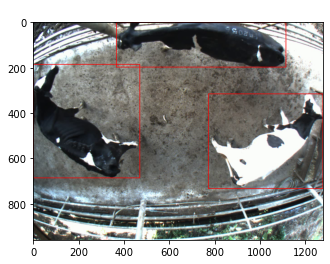

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [6]:
import time
# clear display
from IPython.display import clear_output
for i in range(100):
    plotcow(i, showAll=True, show_filename=True)
    time.sleep(2)
    # clear display
    clear_output(wait=True)

In [ ]:
def makedata():
    # create directory cropped cow images
    if not os.path.exists('./cropped_cow'):
        os.makedirs('./cropped_cow')

    # Create dataset
    for image in tqdm(dataframe['id']['image'].unique()):
        selected = dataframe[dataframe['id']['image'] == image]
        # create directory for each image
        if not os.path.exists(f'./cropped_cow/{image}'):
            os.makedirs(f'./cropped_cow/{image}')
        
        # read image
        img = cv2.imread(f"./cow_data/{image}.png")
        for i in range(3):
            # crop image and save
            try:
                idx = selected[selected['id']['cow'] == i].index[0]
                xmin = (selected['cow-box']['xmin'][idx] * img.shape[1]).astype(int)
                xmax = (selected['cow-box']['xmax'][idx] * img.shape[1]).astype(int)
                ymin = (selected['cow-box']['ymin'][idx] * img.shape[0]).astype(int)
                ymax = (selected['cow-box']['ymax'][idx] * img.shape[0]).astype(int)
                # increase box size by 10%
                xmin = int(xmin - (xmax - xmin) * 0.1)
                xmax = int(xmax + (xmax - xmin) * 0.1)
                ymin = int(ymin - (ymax - ymin) * 0.1)
                ymax = int(ymax + (ymax - ymin) * 0.1)
                # make sure not out of bounds
                if xmin < 0:
                    xmin = 0
                if xmax > img.shape[1]:
                    xmax = img.shape[1]
                if ymin < 0:
                    ymin = 0
                if ymax > img.shape[0]:
                    ymax = img.shape[0]
                # crop image
                crop_img = img[ymin:ymax, xmin:xmax]
                # crop_img = img[ymin:ymax, xmin:xmax]
                
                eatus_label = selected['label']['estrus_label'][idx]
                if eatus_label == 1:
                    estrus_label = 'estrus'
                    cv2.imwrite(f'./cropped_cow/{image}/{i}_{estrus_label}.png', crop_img)
                else:
                    estrus_label = 'not_estrus'
                    cv2.imwrite(f'./cropped_cow/{image}/{i}_{estrus_label}.png', crop_img)
                
                del crop_img

            except IndexError:
                print(f'No Cow {i} In Image: {image}')

makedata()

In [9]:
selected[selected['id']['cow'] == 0].index[0]

18

In [8]:
selected = dataframe[dataframe['id']['image'] == 'img1264']
selected.head()

id      size        cow-box                                          \
      image cow     w    h      xmax      xmin      ymax      ymin   xcenter   
18  img1264   0  1280  960  0.406358  0.080709  0.628073  0.176341  0.243533   
19  img1264   2  1280  960  0.752893  0.185907  0.595070  0.241316  0.469400   
20  img1264   1  1280  960  0.494539  0.124025  0.932323  0.637356  0.309282   

                  head                body           tail-head            \
     ycenter         x         y         x         y         x         y   
18  0.402207  0.000000  0.000000  0.216666  0.527778  0.373959  0.437500   
19  0.418193  0.196875  0.258333  0.548959  0.454167  0.728125  0.577778   
20  0.784839  0.000000  0.000000  0.242709  0.875000  0.131250  0.813889   

          label  
   estrus_label  
18            0  
19            1  
20            0

In [10]:
# create dataset from all images in dataset folder
class CowDataset(torch.utils.data.Dataset):
    def __init__(self, path='./cropped_cow/', im_size=(224, 224)) -> None:
        super().__init__()
        self.im_size = im_size
        self.datapath = path
        self.img_folder = os.listdir(self.datapath)
        self.cow_folder = []
        for folder in self.img_folder:
            self.cow_folder.append(os.listdir(f'{self.datapath}{folder}'))
        self.cow_path = []
        for i in tqdm(range(len(self.img_folder))):
            for j in range(len(self.cow_folder[i])):
                self.cow_path.append(f'{self.datapath}{self.img_folder[i]}/{self.cow_folder[i][j]}')

    def __len__(self):
        return len(self.cow_path)

    def __getitem__(self, idx):
        path = self.cow_path[idx]
        img = torchvision.io.read_image(path)
        img = torchvision.transforms.functional.resize(img, self.im_size)
        # img = torchvision.transforms.functional.to_tensor(img)
        # img = torchvision.transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        label = path.split('/')[-1].split('_')[1].split('.')[0]
        if label == 'estrus':
            label = 1
            # print(path)
        else:
            label = 0
        return img, label


In [11]:
cowloader = CowDataset() 

100%|██████████| 2000/2000 [00:00<00:00, 286790.02it/s]


In [12]:
for x, y in cowloader:
    print(x.shape, 'Classes:', y)
    break

dataloaders = torch.utils.data.DataLoader(cowloader, batch_size=4, shuffle=True, num_workers=0) # can't use num_workers > 0
for data, label in dataloaders:
    print(data.shape, label)
    break
del dataloaders

torch.Size([3, 224, 224]) Classes: 0
torch.Size([4, 3, 224, 224]) tensor([0, 1, 1, 0])


In [13]:
# dataloader train and test split
train_size = int(0.6 * len(cowloader))
test_size = len(cowloader) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(cowloader, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)
# count for eatus and not eatus in test and train
train_eatus = 0
train_not_eatus = 0
test_eatus = 0
test_not_eatus = 0
for data, label in tqdm(train_dataset):
    if label == 1:
        train_eatus += 1
    else:
        train_not_eatus += 1
for data, label in tqdm(test_dataset):
    if label == 1:
        test_eatus += 1
    else:
        test_not_eatus += 1

100%|██████████| 2394/2394 [00:32<00:00, 74.40it/s]


In [14]:
print(train_eatus, train_not_eatus)
print(test_eatus, test_not_eatus)

661 2929
439 1955


In [15]:
# image_classification finetune efficientnet
model = torchvision.models.efficientnet_b0(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = model.to(device)
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 2
#  model to float
model = model.float()

In [174]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [16]:
# train model
from statistics import mode
import time
import copy
# create training function

def train(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    model = model.to(device)
    # will use this for plotting
    log_train_loss = []
    log_valid_loss = []
    log_train_acc = []
    log_valid_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # fix dtype
            inputs = inputs.float()
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
        # log_train_loss.append(epoch_loss)
        # log_train_acc.append(epoch_acc)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if valid_dataloader is not None:
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in valid_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # fix dtype
                inputs = inputs.float()
                labels = labels.long()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                with torch.no_grad():
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(valid_dataloader.dataset)
            epoch_acc = running_corrects.double() / len(valid_dataloader.dataset)
            # log_valid_loss.append(epoch_loss)
            # log_valid_acc.append(epoch_acc)
            print(f'Valid Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'Best model updated with acc {best_acc:.4f}')
        if scheduler is not None:
            scheduler.step()
        # if epoch % checkpoint_epochs == 0:
        #     torch.save(model.state_dict(), f'./model/checkpoint_{epoch}.pth')

    end = time.time()
    print(f'Training complete in {(end-start)/60:.2f} minutes')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, log_train_loss, log_valid_loss, log_train_acc, log_valid_acc


In [17]:
trained_model = train(model, train_loader, test_loader, criterion, optimizer, epochs=num_epochs, device=device)

Training for 2 epochs on cuda
Epoch 1/2


100%|██████████| 898/898 [03:08<00:00,  4.75it/s]


Train Loss: 0.4537 Acc: 0.8081
Valid Loss: 0.3750 Acc: 0.8300
Best model updated with acc 0.8300
Epoch 2/2


100%|██████████| 898/898 [03:07<00:00,  4.78it/s]


Train Loss: 0.3787 Acc: 0.8318
Valid Loss: 0.3605 Acc: 0.8317
Best model updated with acc 0.8317
Training complete in 8.02 minutes
Best val Acc: 0.8317


In [18]:
# predict all test images
model.eval()
pred = []
label = []
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).long()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.extend(predicted.cpu().numpy())
        label.extend(labels.cpu().numpy())

100%|██████████| 599/599 [00:49<00:00, 12.04it/s]


In [19]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(label, pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1955
           1       0.54      0.55      0.55       439

    accuracy                           0.83      2394
   macro avg       0.72      0.72      0.72      2394
weighted avg       0.83      0.83      0.83      2394



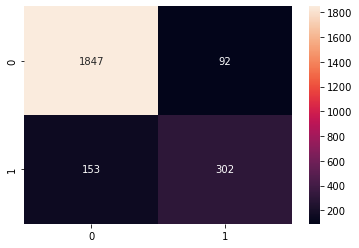

In [179]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()